El objetivo de este notebook es plotear y analizar tiempos / spikes de experimentos. Por un lado cargamos un archivo donde se indica el tiempo de activación del láser, y por otro tenemos los spikes. Tenemos que plotear primero, de manera coordinada, la información de ambos archivos.

In [702]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import datetime as dt
import os
import seaborn as sns

In [703]:
hoy = dt.date.today()

In [704]:
df_times = pd.read_csv('tiempos.csv', sep=', ', index_col='FileName')
df_times

/var/folders/b0/y3jz8svn7n3c3f_4751rp9480000gn/T/ipykernel_1646/2140088795.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_times = pd.read_csv('tiempos.csv', sep=', ', index_col='FileName')


,BlockVectorStartTime,ExperimentStartTime,AddedDate,ModifiedDate
FileName,,,,
D19_POSTsiembra_A1_(I)(001),10:25:6:151,10:6:50:631,10:25:6:184,10:28:28:239
D19_POSTsiembra_A1_(IV)(000),13:34:52:865,13:19:42:670,13:34:52:893,13:38:15:240
D19_POSTsiembra_A2_(I)(000),10:29:16:950,10:6:50:631,10:29:16:977,10:32:40:216
D19_POSTsiembra_A2_(IV)(000),13:38:56:836,13:19:42:670,13:38:56:863,13:42:17:750
D19_POSTsiembra_A3_(I)(000),10:33:19:233,10:6:50:631,10:33:19:265,10:36:37:940
D19_POSTsiembra_A3_(IV)(000),13:43:46:987,13:19:42:670,13:43:47:20,13:47:4:0
D19_POSTsiembra_A4_(I)(000),10:37:49:212,10:6:50:631,10:37:49:240,10:41:7:202
D19_POSTsiembra_A4_(IV)(000),13:47:48:851,13:19:42:670,13:47:48:880,13:51:31:757
D19_POSTsiembra_A5_(IV)(000),13:52:19:515,13:19:42:670,13:52:19:556,13:55:38:17


In [705]:
exp_date = '2024_02_20'

name_sample = 'D19_POSTsiembra_C2_(IV)(000)'
name_file_spikes = f'{name_sample}_spike_list.csv'
name_file_laser = '202402020_MEAs_C2_(IV).csv'

timestamp = [int(i) for i in df_times['ModifiedDate'].loc[name_sample].split(':')]

time_absolute_start = dt.datetime.combine(hoy, dt.time(timestamp[0], timestamp[1], timestamp[2], timestamp[3] * 1000))  # A1_(IV)_(000)

os.makedirs(f'../../results/{exp_date}', exist_ok=True)


time_absolute_start

datetime.datetime(2024, 2, 29, 14, 16, 20, 279000)

In [706]:
#df_spikes = pd.read_csv(f"../../spike_lists/{exp_date}/{name_file_spikes}", sep='\t', encoding='unicode_escape')
df_spikes = pd.read_csv(f"../../spike_lists/{exp_date}/{name_file_spikes}", sep=';', encoding='unicode_escape')
df_spikes['electrode_str'] = [i.split('_')[1] for i in df_spikes['Electrode']]
df_spikes['electrode_coord'] = [(int(electrode[0]) - 1, 3 - (int(electrode[1]) - 1)) for electrode in df_spikes['electrode_str']]
df_spikes

,ï»¿Investigator,Unnamed: 1,Time (s),Electrode,Amplitude (mV),electrode_str,electrode_coord
0,Recording Name,D19_POSTsiembra_C2_(IV),0.00792,C2_21,0.016,21,"(1, 3)"
1,Description,NaN,0.23968,C2_21,0.019,21,"(1, 3)"
2,Maestro Edge (Maestro-091) Settings,NaN,0.46632,C2_21,0.020,21,"(1, 3)"
3,Original File Time,02/20/2024 14:12:38,0.47912,C2_14,0.020,14,"(0, 0)"
4,Sampling Frequency,12.5 kHz,0.49224,C2_43,0.038,43,"(3, 1)"
...,...,...,...,...,...,...,...
43951,NaN,NaN,221.53072,C2_11,0.056,11,"(0, 3)"
43952,NaN,NaN,221.53648,C2_31,0.017,31,"(2, 3)"
43953,NaN,NaN,221.54472,C2_32,0.020,32,"(2, 2)"
43954,NaN,NaN,221.55696,C2_21,0.027,21,"(1, 3)"


In [707]:
df_laser = pd.read_csv(f"../../tiempos_structura/{exp_date}/{name_file_laser}", index_col=0)

list_start_times, list_end_times = [], []


# Modify dates
for value_on, value_off in zip(df_laser['Turn ON Laser Time'].values, df_laser['Turn OFF Laser Time'].values):
    value_on, value_off = value_on.replace(':', '.'), value_off.replace(':', '.')
    tuple_on = (int(value_on.split('.')[0]), int(value_on.split('.')[1]), int(value_on.split('.')[2]), int(value_on.split('.')[3]))
    tuple_off = (int(value_off.split('.')[0]), int(value_off.split('.')[1]), int(value_off.split('.')[2]), int(value_off.split('.')[3]))

    list_start_times.append((dt.datetime.combine(hoy, dt.time(tuple_on[0], tuple_on[1], tuple_on[2], tuple_on[3]))  - time_absolute_start).total_seconds())
    list_end_times.append((dt.datetime.combine(hoy, dt.time(tuple_off[0], tuple_off[1], tuple_off[2], tuple_off[3]))  - time_absolute_start).total_seconds())


df_laser['start_times'], df_laser['end_times'] = list_start_times, list_end_times
df_laser['duration'] = df_laser['ON duration (ms)'] / 1000
df_laser


,Repetition,ON duration (ms),Laser Power (mW),Turn ON Laser Time,Turn OFF Laser Time,Turn ON Laser Time (ms),start_times,end_times,duration
0,1,100,0,14:12:41.152596,14:12:41.254352,0 days 00:00:00.101756,-219.126404,-219.024648,0.1
1,2,100,0,14:12:44.293235,14:12:44.394917,0 days 00:00:00.101682,-215.985765,-215.884083,0.1
2,3,100,0,14:12:47.431404,14:12:47.541974,0 days 00:00:00.110570,-212.847596,-212.737026,0.1
3,4,100,0,14:12:50.576784,14:12:50.679829,0 days 00:00:00.103045,-209.702216,-209.599171,0.1
4,5,100,0,14:12:53.706588,14:12:53.816606,0 days 00:00:00.110018,-206.572412,-206.462394,0.1
5,6,100,0,14:12:56.840345,14:12:56.950332,0 days 00:00:00.109987,-203.438655,-203.328668,0.1
6,7,100,0,14:12:59.980263,14:13:00.080285,0 days 00:00:00.100022,-200.298737,-200.198715,0.1
7,8,100,0,14:13:03.106246,14:13:03.216307,0 days 00:00:00.110061,-197.172754,-197.062693,0.1
8,9,100,0,14:13:06.237230,14:13:06.337267,0 days 00:00:00.100037,-194.041770,-193.941733,0.1
9,10,100,0,14:13:09.367226,14:13:09.467282,0 days 00:00:00.100056,-190.911774,-190.811718,0.1


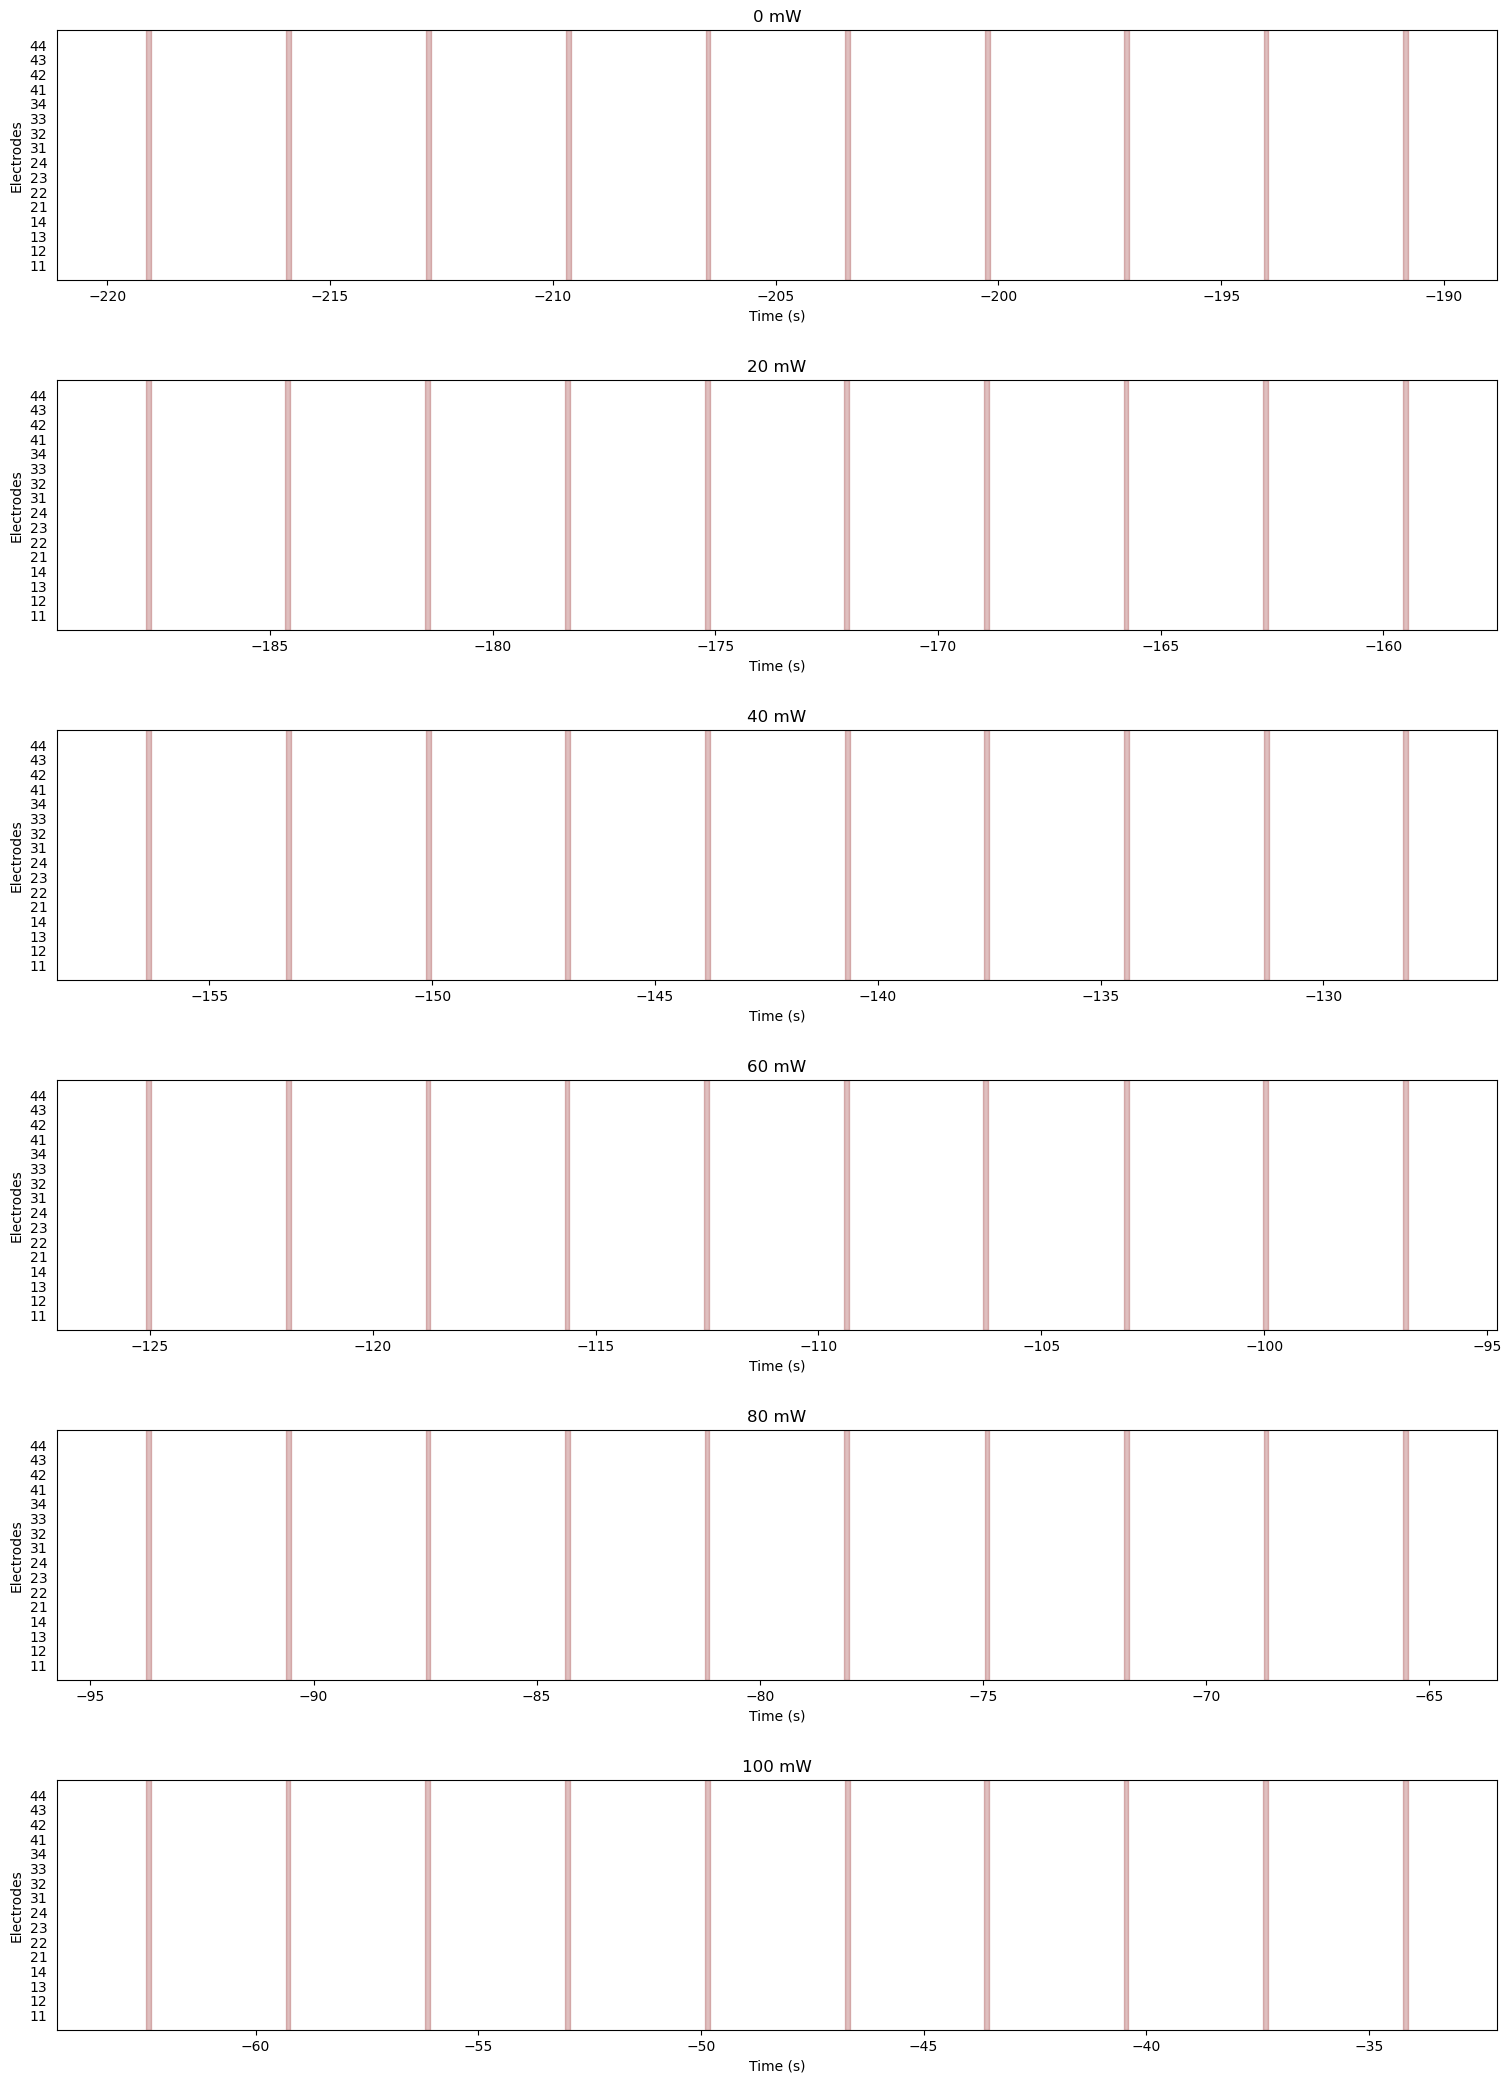

In [708]:
voltages = sorted(set(df_laser['Laser Power (mW)'].values))
electrodes = sorted(set(df_spikes['electrode_str'].values))

window = 2

fig, axs = plt.subplots(len(voltages), 1, figsize=(18, 25))


for idx, voltage in enumerate(voltages):
    df_laser_sub = df_laser[df_laser['Laser Power (mW)'] == voltage]
    t_0, t_f = min(df_laser_sub['start_times']), max(df_laser_sub['end_times'])


    for rep, start, end in zip(df_laser_sub['Repetition'].values, df_laser_sub['start_times'].values, df_laser_sub['end_times'].values):
        axs[idx].add_patch(mpl.patches.Rectangle((start, -1), end - start, len(electrodes)+1, alpha=0.25, color='#800000'))

    for electrode_idx, electrode in enumerate(electrodes):
        df_spikes_sub = df_spikes[(df_spikes['Time (s)'] > t_0 - window) & (df_spikes['Time (s)'] < t_f + window) & (df_spikes['electrode_str'] == electrode)]
        axs[idx].scatter(x=df_spikes_sub['Time (s)'].values, y=[electrode_idx] * len(df_spikes_sub), marker='|', s=100, c='#7f7f7f')
    


    axs[idx].set_yticks(np.array(range(len(electrodes))))
    axs[idx].set_yticklabels(electrodes)
    axs[idx].set_ylim([-1, len(electrodes)])
    axs[idx].set_xlim([t_0 - window, t_f+window])
    axs[idx].tick_params(left = False)
    axs[idx].set_xlabel('Time (s)')
    axs[idx].set_ylabel('Electrodes')

    axs[0].title.set_text('0 mW')
    axs[1].title.set_text('20 mW')
    axs[2].title.set_text('40 mW')
    axs[3].title.set_text('60 mW')
    axs[4].title.set_text('80 mW')
    axs[5].title.set_text('100 mW')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.savefig(f'../../results/{exp_date}/ModifiedDate/{name_sample}_ModifiedDate.png', dpi=300)

# Calculating the mean representation time between pulses

In [709]:
tw = 0.1

time_ranges = np.arange(np.min(df_laser['start_times']) , np.max(df_laser['end_times']) , tw)
time_ranges_mean = (time_ranges[1:] + time_ranges[:-1]) * 0.5 

counts = np.array([len(df_spikes[(df_spikes['Time (s)'] >= start) & (df_spikes['Time (s)'] < end)]) for start, end in zip(time_ranges[:-1], time_ranges[1: ])])
len(counts)


1850

/Users/aneescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

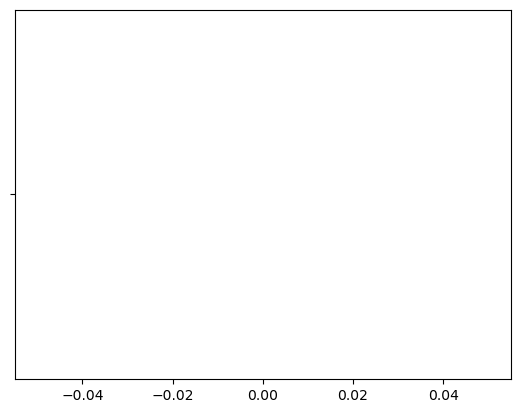

In [710]:
tmps = np.argwhere(counts > 80).flatten() * tw
diff = tmps[1: ] - tmps[: -1]
sns.swarmplot(diff[diff > 2 * tw])

